# Projeto 1 - Rede Neural do zero!


In [1]:
# Importando as bibliotecas necessárias
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

In [2]:
transform = transforms.ToTensor() # Definindo a conversão de imagem para tensor

trainset = datasets.MNIST('MNIST_data/', download=True, train=True, transform=transform) # Carregando o dataset de treino
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True) # Carregando o dataset de treino

valset = datasets.MNIST('MNIST_data/', download=True, train=False, transform=transform) # Carregando o dataset de validação
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True) # Carregando o dataset de validação

100%|██████████| 9912422/9912422 [00:00<00:00, 224269276.28it/s]

Extracting MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 113422934.29it/s]


Extracting MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 124189976.24it/s]

Extracting MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 1117202.02it/s]


Extracting MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw



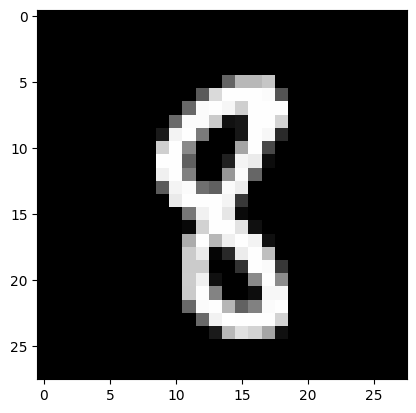

In [5]:
dataiter = iter(trainloader) # Criando um iterador para o dataset de treino
imagens, etiquetas = next(dataiter) # Carregando um batch de imagens e etiquetas
plt.imshow(imagens[0].numpy().squeeze(), cmap='Greys_r'); # Visualizando uma imagem do batch

In [6]:
print(imagens.shape) # Imprimindo o shape do batch de imagens, dimensões do tensor
print(etiquetas[0].shape) # Verificar as dimensões do tensor de etiquetas

torch.Size([1, 28, 28])
torch.Size([])

torch.Size([64, 1, 28, 28])
torch.Size([])


torch.Size([])

In [7]:
# Definições da REDE InceptionV3

class Modelo(nn.Module):
    def __init__(self):
        super(Modelo, self).__init__()
        self.linear1 = nn.Linear(28*28, 128) # Camada de entrada com 784 neurônios e camada oculta com 128 neurônios
        self.linear2 = nn.Linear(128, 64) # Camada oculta com 128 neurônios e camada oculta com 64 neurônios
        self.linear3 = nn.Linear(64, 10) # Camada oculta com 64 neurônios e camada de saída com 10 neurônios
        # Para a camada de saída não é necessário definir a dimensão de entrada, pois somente precisamos pegar o output da camada interna 2
        
    def forward(self, x):
        X = F.relu(self.linear1(X)) # Aplicando a função de ativação ReLU na camada de entrada
        X = F.relu(self.linear2(X)) # Aplicando a função de ativação ReLU na camada oculta
        X = self.linear3(X) # Aplicando a função de ativação ReLU na camada de saída
        return F.log_softmax(X, dim=1) # Aplicando a função de ativação Softmax na camada de saída

In [8]:
def treino(modelo, trainloader, device):
    
    otimizador = optim.SGD(modelo.parameters(), lr=0.001, momentum=0.5) # Definindo a politica de atualização dos pesos e da bias
    inicio = time() # Iniciando a contagem do tempo de treino
    
    criterio = nn.NLLLoss() # Definindo o critério para calcular a perda
    EPOCHS = 10 # Definindo o número de épocas que o modelo irá treinar
    modelo.train() # Definindo o modelo para treino
    
    for epoch in range(EPOCHS):
        perda_acumulada = 0 # Definindo a perda acumulada para cada época
        
        for imagens, etiquetas in trainloader: # Iterando sobre o dataset de treino
            
            imagens = imagens.view(imagens.shape[0], -1) # Redimensionando as imagens para o formato de vetor de 28x28 para ficarem compatíveis com a camada de entrada
            otimizador.zero_grad() # Zerando os gradientes por conta do cliclo anterior
            
            output = modelo(imagens.to(device)) # Colocando os dados no modelo
            perda_instantanea = criterio(output, etiquetas.to(device)) # Calculando a perda da epoch em questão
            
            perda_instantanea.backward() # Calculando os gradientes
            
            otimizador.step() # Atualizando os pesos e bias
            
            perda_acumulada += perda_instantanea.item() # Acumulando a perda da epoch em questão
            
        else:
            print("Epoch {} - Perda resultante: {}".format(epoch+1, perda_acumulada/len(trainloader))) # Imprimindo a perda da epoch em questão
    
    print("\nTempo de treino (em minutos) = ", (time()-inicio)/60) # Imprimindo o tempo de treino em minutos

# Realizando a Verificação:

In [9]:
def validacao(modelo, valloader, device):
    conta_corretas, conta_todas = 0, 0 # Definindo as variáveis para contar as predições corretas e todas as predições
    for imagens, etiquetas in valloader:
        for i in range(len(etiquetas)):
            img = imagens[i].view(1, 784) # Redimensionando a imagem para o formato de vetor de 28x28 para ficarem compatíveis com a camada de entrada
            # Desativar o autograd para acelerar o processo de validação. Grafos computacionais dinâmicos tem um curto alto de processamento
            with torch.no_grad():
                logps = modelo(img.to(device)) # Colocando os dados no modelo
                
            ps = torch.exp(logps) # Calculando a probabilidade de cada classe
            probab = list(ps.cpu().numpy()[0]) # Convertendo para numpy e pegando a probabilidade de cada classe
            etiqueta_pred = probab.index(max(probab)) # Pegando a classe com maior probabilidade
            etiqueta_certa = etiquetas.numpy()[i] # Pegando a classe correta
            
            if(etiqueta_certa == etiqueta_pred): # Verificando se a predição foi correta
                conta_corretas += 1
            conta_todas += 1
            
    print("Total de imagens: ", conta_todas) # Imprimindo o total de imagens
    print("\nPrecisão do modelo = {:.2f}%".format((conta_corretas/conta_todas)*100)) # Imprimindo a precisão do modelo

# Leitura do Modelo:

In [10]:
modelo = Modelo()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Definindo o dispositivo de processamento
modelo.to(device) # Colocando o modelo no dispositivo de processamento

Modelo(
  (linear1): Linear(in_features=784, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=10, bias=True)
)